# fMRI Demo (nilearn version)

## About this demo

In this demo we'll show how to use the python *nilearn* library to create multi-voxel patterns and then how to use these in the *rsatoolbox* to create RDMs. See the [patterns demo](https://rsatoolbox.readthedocs.io/en/stable/demo_fmri_patterns.html) for a more birds-eye view of the analysis pipeline, with a larger portion of the dataset, including inference.

## The Dataset

The data used for this demo was kindly provided by Marieke Mur ([Mur et al, 2025](https://www.biorxiv.org/content/10.1101/2025.06.18.660183v1)). This study is still under review, so we will update this demo to include steps to download the data when it becomes publicly available. 

Participants (n=14) viewed images of 16 objects, as well as their written name. Several properties of the stimuli were carefully balanced. They also performed several tasks, but for the purposes of this demo we will ignore these.

![stimuli](demo_fmri_files/mur32_stims.png)

This library depends on *nibabel* for convenience functions to access MRI data, and is used separately in the demo as well, so start by installing nibabel (`pip install nibabel`).

Then run the following imports:

In [1]:
%matplotlib inline
from os.path import expanduser, join
from rsatoolbox.io.fmriprep import find_fmriprep_runs
from rsatoolbox.data.dataset import Dataset, merge_datasets
from rsatoolbox.vis import show_rdm
from rsatoolbox.rdm.calc import calc_rdm
from rsatoolbox.data.noise import prec_from_residuals
import numpy, pandas, matplotlib.pyplot
import nibabel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

Now we define the path to the BIDS-root data directory

In [2]:
data_dir = expanduser('~/data/rsatoolbox/mur32')

Next we use a utility function to find the relevant preprocessed BOLD images:

In [3]:
runs = find_fmriprep_runs(data_dir, tasks=['main'])
len(runs)

84

Let's select all the runs for participant *sub-12*:

In [4]:
runs = [run for run in runs if run.boldFile.sub == '12']
len(runs)

6

Each run object carries the relevant data and metadata

In [5]:
run = runs[0]
run

<FmriprepRun [sub-12/ses-01/func/sub-12_ses-01_task-main_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz]>

In [6]:
dims = run.get_data().shape ## bold timeseries: x * y * z * volumes
n_vols = dims[-1]
dims

(275275, 546)

Access the attributes stored in the *_metadata.json* for this file

In [7]:
tr = run.get_meta()['RepetitionTime'] ## TR in seconds
tr

2

We will also load the events table

In [8]:
run.get_events().sample(5) ## 5 random events

,onset,duration,trial_type,modality,identity,response_time,task,response_mapping
274,821.997,0.5,baseline,NaN,NaN,NaN,NaN,NaN
118,353.985,0.5,text_candle,text,candle,0.839,semantic,right-left
123,368.991,0.5,image_ladder,image,ladder,0.897,semantic,right-left
265,794.987,0.5,image_helmet,image,helmet,1.792,fixation,left-right
230,689.997,0.5,baseline,NaN,NaN,NaN,NaN,NaN


In [9]:
run.get_confounds().head(3)

,global_signal,csf,white_matter,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,490.950364,852.897339,454.706819,-0.031540,-0.278969,-0.171883,0.003922,0.001695,-0.001443
1,488.731823,841.926156,454.439092,0.004438,-0.155145,-0.161355,0.004182,0.001695,-0.000628
2,488.417947,836.871638,454.370054,0.005771,-0.200537,-0.150666,0.004127,0.001523,-0.001216


## Patterns

Next we want to establish Multi-Voxel Patterns from the timeseries, such that, for each stimulus presentation, we have one observation per voxel. The most common way to do this is with a General Linear Model, where each predictor in the model reflects one type of event, convolved with the haemodynamic response function (HRF). For the purposes of this demo we will use a very basic glm implementation in Python. For a guide on MVPA, see [Mur et al. 2009](https://doi.org/10.1093/scan/nsn044).

First we use a utility function which creates predictors from the events table and convolves them with the HRF. Note that we have 34 predictors, with a value for each volume in the BOLD timeseries. 

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: response_mapping, response_time, modality, identity, task
  warnings.warn(


<Axes: label='conditions', ylabel='scan number'>

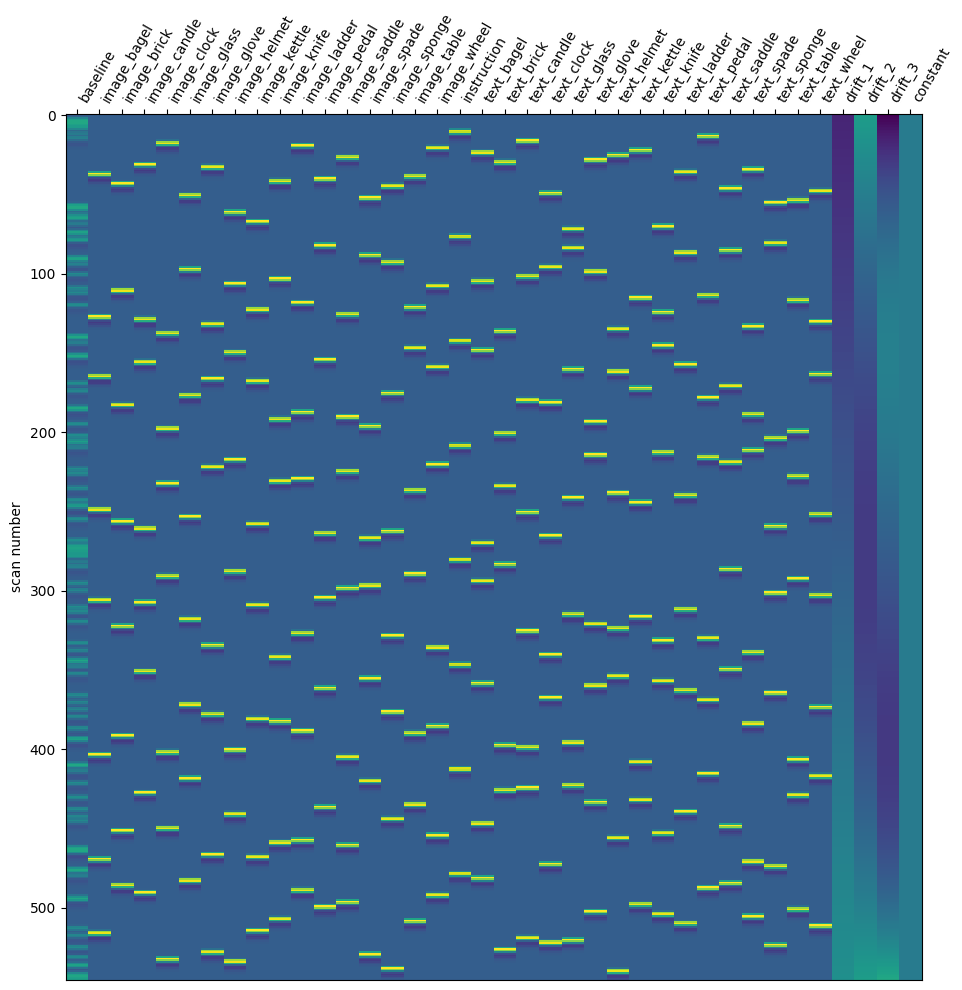

In [10]:


frame_times = numpy.linspace(0, tr*(n_vols-1), n_vols) ## [0, 2, 4] onsets of scans in seconds
design_matrix = make_first_level_design_matrix(
    frame_times,
    run.get_events(),
    drift_model='polynomial',
    drift_order=3)
plot_design_matrix(design_matrix)

This plot shows the design matrix. Every blip reflects the haemodynamic response to a single trial.

### GLM
Here we fit nilearn's implementation of the GLM

In [11]:
from nilearn.glm.first_level import FirstLevelModel
glm = FirstLevelModel(
    t_r=tr,
    mask_img=False,
    minimize_memory=False,
    signal_scaling=0,
    n_jobs=-2
)
glm.fit([run.boldFile.fpath], design_matrices=design_matrix)

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


FirstLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x317ead2d0>,
                minimize_memory=False, n_jobs=-2, t_r=2)

In [12]:
conditions = [c for c in design_matrix.columns if ('image_' in c) or ('text_' in c)]
conditions

['image_bagel',
 'image_brick',
 'image_candle',
 'image_clock',
 'image_glass',
 'image_glove',
 'image_helmet',
 'image_kettle',
 'image_knife',
 'image_ladder',
 'image_pedal',
 'image_saddle',
 'image_spade',
 'image_sponge',
 'image_table',
 'image_wheel',
 'text_bagel',
 'text_brick',
 'text_candle',
 'text_clock',
 'text_glass',
 'text_glove',
 'text_helmet',
 'text_kettle',
 'text_knife',
 'text_ladder',
 'text_pedal',
 'text_saddle',
 'text_spade',
 'text_sponge',
 'text_table',
 'text_wheel']

In [13]:
beta_img = glm.compute_contrast('image_glove', output_type='effect_size')

The output of this is a statistical map; a whole-brain volume with a beta-weight for every voxel. 

## Defining a Region-of-Interest
We want to sample a pattern for a specific brain region. Luckily this *fmriprep* run comes with the *aparcaseg* parcellation map projected into the subject's space. Let's use this atlas to create a *mask* for the Fusiform Gyrus.

In [14]:
# Navigate to the aparcaseg file for this run:
aparc = run.boldFile.get_mri_sibling(desc='aparcaseg', suffix='dseg')
aparc_data = aparc.get_data()
print(aparc_data.shape)
print(numpy.unique(aparc_data[:10]))

(65, 77, 55)
[   0. 1001. 1015. 1022. 1030. 1031.]


As we see, this is a volume with an whole number at every voxel. We can use the corresponding lookup-table (LUT) to understand these numbers:

In [15]:
lut_fpath = join(data_dir, 'derivatives', 'fmriprep',
                 'desc-aparcaseg_dseg.tsv')
lut_df = pandas.read_csv(lut_fpath, sep='\t')
lut_df

,index,name,color
0,0,Unknown,#000000
1,1,Left-Cerebral-Exterior,#4682b4
2,2,Left-Cerebral-White-Matter,#f5f5f5
3,3,Left-Cerebral-Cortex,#cd3e4e
4,4,Left-Lateral-Ventricle,#781286
...,...,...,...
1369,14171,wm_rh_S_suborbital,#15143c
1370,14172,wm_rh_S_subparietal,#653c3c
1371,14173,wm_rh_S_temporal_inf,#15b4b4
1372,14174,wm_rh_S_temporal_sup,#dfdc3c


Now let's find the numbers that correspond to the Fusiform Gyrus in the left- and right hemisphere:

In [16]:
matches = lut_df[lut_df['name'] == 'ctx-lh-fusiform']
left_index = matches['index'].values[0]
matches = lut_df[lut_df['name'] == 'ctx-rh-fusiform']
right_index = matches['index'].values[0]
left_index, right_index

(1007, 2007)

Index the atlas with these numbers and combine into a single mask:

In [17]:
fusiform_mask = numpy.zeros_like(aparc_data, dtype=bool)
fusiform_mask[aparc_data == float(left_index)] = True
fusiform_mask[aparc_data == float(right_index)] = True

Let's see how many voxels are in the mask:

In [18]:
roi_size = fusiform_mask.sum()
roi_size

829

Let's have a look at this Region-of-Interest (ROI)

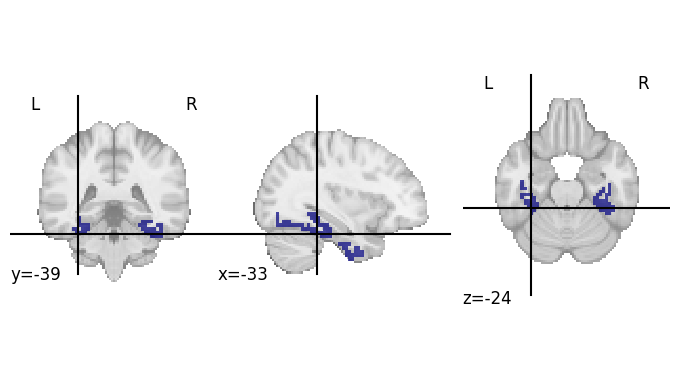

In [19]:
from nilearn.plotting import plot_roi
# borrow the affine transformation for this new image from their sibling
affine = nibabel.load(aparc.fpath).affine 
plot_roi(
    nibabel.nifti1.Nifti1Image(
        fusiform_mask*1.0,  # the plotting image requires a float-based mask
        affine=affine
    )
)

## Creating a Dataset

Now we are able to select only the betas for this ROI:

In [20]:
pattern = beta_img.get_fdata()[fusiform_mask]
pattern.shape, pattern[-10:]

((829, 1),
 array([[157.67828937],
        [  6.57029055],
        [  6.43865366],
        [  6.12197048],
        [-10.46893236],
        [ 16.69253657],
        [-72.01982946],
        [-17.89987039],
        [ -4.91374503],
        [ -1.04137262]]))

Let's also collect the patterns for the other conditions

In [21]:
patterns = numpy.full([len(conditions), roi_size], numpy.nan)
for c, condition in enumerate(conditions):
    beta_img = glm.compute_contrast(condition, output_type='effect_size')
    patterns[c, :] = beta_img.get_fdata()[fusiform_mask].squeeze()

The run object then provides us with dictionaries with attributes that identify this run and its various dimensions. These map unto the rsatoolbox *descriptors*.

In [22]:
run.get_dataset_descriptors()

{'sub': '12', 'ses': '01', 'run': '01', 'task': 'main'}

We can then combine the patterns and descriptors to create an rsatoolbox `Dataset` object

In [23]:
ds = Dataset(
    measurements=patterns,
    descriptors=run.get_dataset_descriptors(),
    obs_descriptors=dict(condition=conditions),
)

## Noise

If we want to apply multivariate noise normalization, we should also collect and process a measure of the noise of our observation. The *nilearn* glm can provide us with the residuals (e.g. error) of the GLM:

In [24]:
resid_img = glm.residuals[0]
resid_img.get_fdata().shape

(65, 77, 55, 546)

These we can also limit to the extend of our ROI:

In [25]:
resids = resid_img.get_fdata()[fusiform_mask, :].T
resids.shape

(546, 829)

Next we need to determine the degrees-of-freedom for our design. This is the number of columns in the design matrix figure above; 
- 32 stimulus conditions
- the "baseline" and "instruction" conditions
- 4 confound predictors

In [26]:
degrees_of_freedom = 38

We can then calculate a noise precision matrix:

In [27]:
prec_matrix = prec_from_residuals(
    resids,
    dof=degrees_of_freedom,
    method='shrinkage_diag'
)
prec_matrix

array([[0.02081756, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01565435, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05739469, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00942196, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03871096,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02422791]])

## Calculating RDMs

Now that we have the Dataset and noise precision, we can calculate an RDM for this single run:

In [28]:
rdms = calc_rdm(
    dataset=ds,
    noise=prec_matrix,
    method='mahalanobis',
    descriptor='condition',
)
rdms

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
squared mahalanobis
dissimilarities = 
[[0.38365942 0.33658986 0.31859911 0.29808972 0.3224023  0.42602224
  0.37384069 0.31120577 0.34875965 0.31970565 0.35857025 0.36532242
  0.35291608 0.30943487 0.4088163  0.35436635 0.3157959  0.40211281
  0.39414911 0.35124768 0.29041107 0.49595231 0.32703596 0.43430263
  0.30354277 0.32431712 0.32335989 0.31068237 0.32235356 0.38775498
  0.37401073 0.34064614 0.46852911 0.29005866 0.35930841 0.34972533
  0.33482445 0.44607791 0.30067009 0.36044098 0.35054297 0.46780848
  0.40660717 0.35586898 0.298206   0.33660109 0.4475611  0.32698626
  0.37007769 0.36586169 0.40355882 0.52560357 0.30387521 0.35904086
  0.37814055 0.37914135 0.50645511 0.34805984 0.37793495 0.36994403
  0.33578252 0.32183139 0.29427345 0.32296704 0.38577602 0.29622093
  0.34148527 0.3063691  0.35274345 0.31752502 0.33553897 0.36076734
  0.29295141 0.37303643 0.3295859  0.37702671 0.30051722 0.31803179
  0.33935567 0.30397038 0.41060

Now, instead of making an RDM for every run, we could use crossvalidation across the runs to get an RDM of the "crossnobis" dissimilarity. So let's loop across the runs:

In [41]:
run_datasets = []
prec_matrices = []

for r, run in enumerate(runs):
    design_matrix = make_first_level_design_matrix(
        frame_times,
        run.get_events(),
        drift_model='polynomial',
        drift_order=3
    )
    glm = FirstLevelModel(
        t_r=tr,
        mask_img=False,
        minimize_memory=False,
        signal_scaling=0,
        n_jobs=-2
    )
    glm.fit([run.boldFile.fpath], design_matrices=design_matrix)
    
    patterns = numpy.full([len(conditions), roi_size], numpy.nan)
    for c, condition in enumerate(conditions):
        beta_img = glm.compute_contrast(condition, output_type='effect_size')
        patterns[c, :] = beta_img.get_fdata()[fusiform_mask].squeeze()

    descs = run.get_dataset_descriptors()
    descs['run'] = str(r)
    run_datasets.append(
        Dataset(
            measurements=patterns,
            descriptors=descs,
            obs_descriptors=dict(condition=conditions),
        )
    )
    resids = glm.residuals[0].get_fdata()[fusiform_mask, :].T
    prec_matrices.append(
        prec_from_residuals(
            resids,
            dof=degrees_of_freedom,
            method='shrinkage_diag'
        )
    )

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: response_mapping, response_time, modality, identity, task
  warnings.warn(
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data 

Now we have to combine the run-wise datasets into one single subject `Dataset`

In [42]:
subject_ds = merge_datasets(run_datasets)

And we can calculate the crossnobis RDM:

In [44]:
rdms = calc_rdm(
    dataset=subject_ds,
    noise=prec_matrices,
    method='crossnobis',
    descriptor='condition',
    cv_descriptor='run',
)

/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/rsatoolbox/data/computations.py:36: RuntimeWarning: invalid value encountered in multiply
  average = np.nan * np.empty(


Last but not least; let's view the RDM:

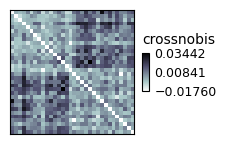

In [45]:
fig, _, _ = show_rdm(rdms, show_colorbar='panel')
matplotlib.pyplot.show()